In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
import math
tokenizer = AutoTokenizer.from_pretrained("microsoft/graphcodebert-base")


In [4]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/graphcodebert-base")
# Initialize empty lists to store the extracted data
groundTruth = []
mockTruth = []
groundDifference = []
mockDifference = []
ntok = []
basePLL = []
sentPLL = []
# store.txt is generated using the output from 2.2-all.py
# Open the text file for reading
with open('store.txt', 'r') as file:
    lines = file.readlines()

# Initialize variables to store the temporary data
current_ground_truth = ""
current_mock_truth = ""
current_ground_difference = None
current_mock_difference = None
current_sent_pll = None
current_base_pll = None
# Iterate over each line in the file
for i in range(len(lines)):
    line = lines[i].strip()

    # Check if the line starts with "Ground truth:"
    if line.find("Ground truth:") != -1:
        current_ground_truth = line.split("Ground truth:")[1].strip()
    # Check if the line starts with "Mock truth:"
    elif line.startswith("Mock truth:"):
        current_mock_truth = line.split("Mock truth:")[1].strip()
    # Check if the line starts with "Net % difference:"
    elif line.startswith("Sent PLL:"):
        # Extract the value from the next line within a tensor
        tensor_line = lines[i + 1].strip()
        current_sent_pll = float(tensor_line.split("tensor(")[1].split(",")[0])
    elif line.startswith("Base Sent PLL:"):
        # Extract the value from the next line within a tensor
        tensor_line = lines[i + 1].strip()
        current_base_pll = float(tensor_line.split("tensor(")[1].split(",")[0])    
    elif line.startswith("Net % difference:"):
        # Extract the value from the next line within a tensor
        tensor_line = lines[i + 1].strip()
        current_ground_difference = float(tensor_line.split("tensor(")[1].split(",")[0])
    # Check if the line starts with "Mock Net % difference:"
    elif line.startswith("Mock Net % difference:"):
        # Extract the value from the next line within a tensor
        tensor_line = lines[i + 1].strip()
        current_mock_difference = float(tensor_line.split("tensor(")[1].split(",")[0])
        # Append the extracted data to the lists
        nt = len(tokenizer.tokenize(current_ground_truth))
        groundTruth.append(current_ground_truth)
        mockTruth.append(current_mock_truth)
        groundDifference.append(current_ground_difference)
        mockDifference.append(current_mock_difference)
        sentPLL.append(current_sent_pll)
        basePLL.append(current_base_pll)
        ntok.append(nt)

Now, the four lists are populated with the extracted data


In [5]:
data = {
    'GroundTruth': groundTruth,
    'MockTruth': mockTruth,
    'GroundDifference': groundDifference,
    'MockDifference': mockDifference,
    'NumTokens':ntok,
    'SentPLL':sentPLL,
    'BasePLL':basePLL
}

# Create a DataFrame
df = pd.DataFrame(data)
df.to_csv('testRes.csv',index=False)

In [ ]:
df = pd.read_csv('testRes.csv')

,GroundTruth,MockTruth,GroundDifference,MockDifference,NumTokens,SentPLL,BasePLL
0,deobfOn,customerOrderShippingAddress,-72.2109,29.5661,4,2.3904,8.6019
1,actionContextRegistry,employeePayrollSystem,-99.8300,-0.8143,4,0.0258,15.1701
2,workerPoolsBuilder,productInventoryItemCount,-80.1683,26.2351,4,2.2525,11.3580
3,fieldAccessors,salesRevenue,-86.7385,-8.3067,3,1.1829,8.9195
4,resolutionStrategy,databaseConnectionPoolSize,-86.4440,12.9442,3,1.9661,14.5034
...,...,...,...,...,...,...,...
222,messageToken,manufacturingDate,-66.7565,24.5230,2,3.3962,10.2160
223,active,connectionPool,-96.2424,-26.3222,1,0.5467,14.5502
224,dotsAndXs,transactionProcessingStatusFlag,-46.2719,-19.9363,5,5.9572,11.0876
225,engine,inventoryItem,-99.9956,12.3351,1,0.0007,14.8146


In [7]:
tot_sent_pll = 0.0
tot_base_pll = 0.0
tot_tok = 0
each_pll = 0.0
base_each_pll = 0.0
for r in range(df.shape[0]):
    sent_pll = df.iloc[r]['SentPLL']
    base_pll = df.iloc[r]['BasePLL']
    tok = df.iloc[r]['NumTokens']
    tot_sent_pll += (sent_pll*tok)
    tot_base_pll += (base_pll*tok)
    tot_tok+= tok
    each_pll+=sent_pll
    base_each_pll+=base_pll

In [8]:
ft_pll = each_pll/df.shape[0]
bm_pll = base_each_pll/df.shape[0]
ft_ppl = math.exp(tot_sent_pll/tot_tok)
bm_ppl = math.exp(tot_base_pll/tot_tok)

In [9]:
print("Average FTM PLL: ", ft_pll)
print("Average BM PLL: ", bm_pll)
print("Average FTM PPL: ", ft_ppl)
print("Average BM PPL: ", bm_ppl)

Average FTM PLL:  2.5991480176211446
Average BM PLL:  10.87725682819383
Average FTM PPL:  22.877751076399782
Average BM PPL:  37580.635142902465


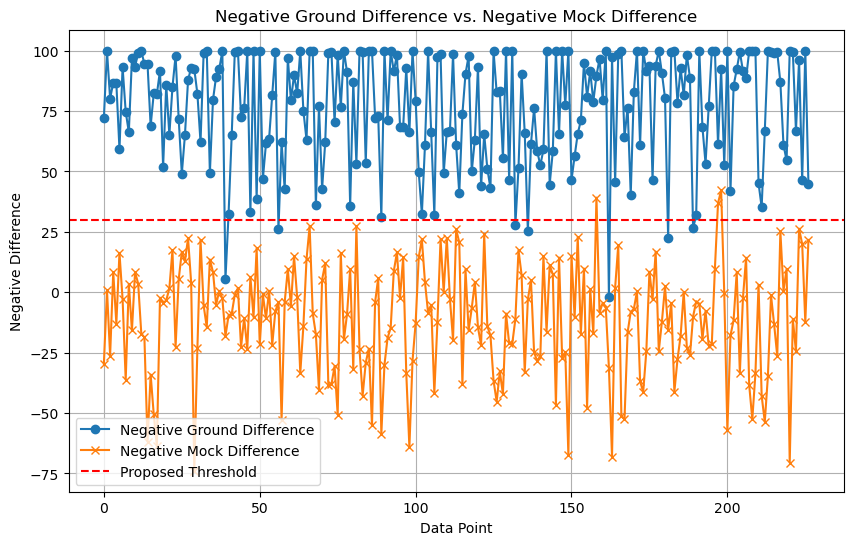

In [12]:
df['NegativeGroundDifference'] = -df['GroundDifference']
df['NegativeMockDifference'] = -df['MockDifference']

# Plot the two columns on the same graph
plt.figure(figsize=(10, 6))
plt.plot(df['NegativeGroundDifference'], label='Negative Ground Difference', marker='o')
plt.plot(df['NegativeMockDifference'], label='Negative Mock Difference', marker='x')

# Add a horizontal line at y=30 with the label "Threshold"
plt.axhline(y=30, color='r', linestyle='--', label='Proposed Threshold')

# Set labels and title
plt.xlabel('Data Point')
plt.ylabel('Negative Difference')
plt.title('Negative Ground Difference vs. Negative Mock Difference')

# Show a legend
plt.legend()

# Display the plot
plt.grid(True)
plt.savefig('my_plot.pdf', format='pdf')
plt.show()

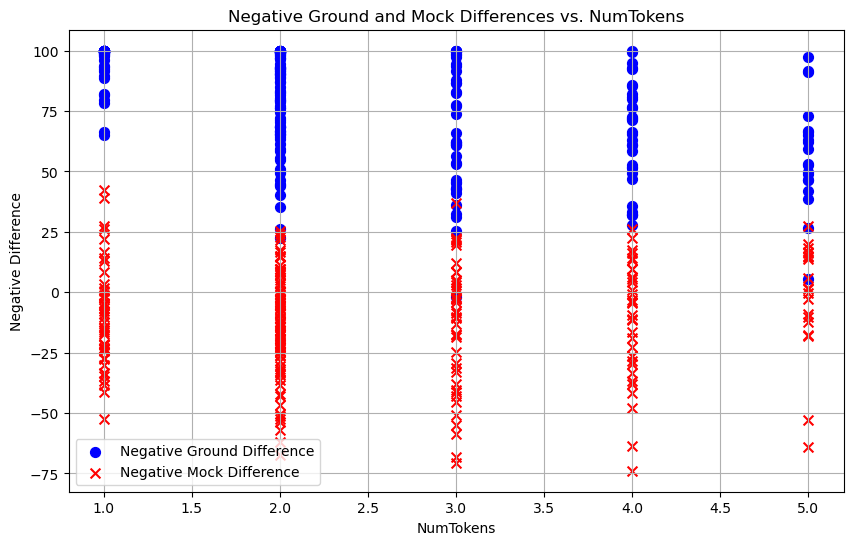

In [13]:
plt.figure(figsize=(10, 6))
plt.scatter(df['NumTokens'], -df['GroundDifference'], label='Negative Ground Difference', marker='o', s=50, c='blue')
plt.scatter(df['NumTokens'], -df['MockDifference'], label='Negative Mock Difference', marker='x', s=50, c='red')

# Set labels and title
plt.xlabel('NumTokens')
plt.ylabel('Negative Difference')
plt.title('Negative Ground and Mock Differences vs. NumTokens')

# Show a legend
plt.legend()

# Display the plot
plt.grid(True)
plt.savefig('my_plot1.pdf', format='pdf')
plt.show()

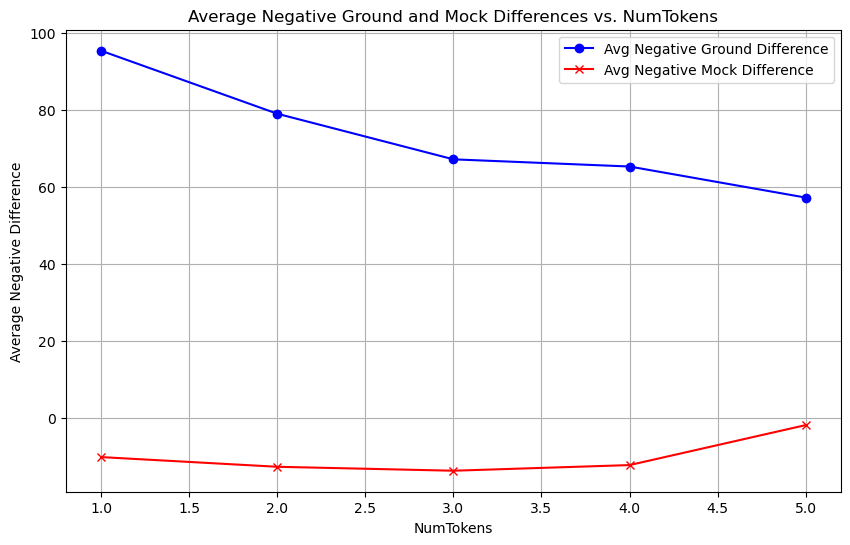

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have already created the DataFrame with the necessary columns (including 'GroundDifference', 'MockDifference', 'NumTokens')
# If not, please ensure you have the DataFrame set up correctly.

# Group the data by 'NumTokens' and calculate the averages
grouped_data = df.groupby('NumTokens').agg({'GroundDifference': 'mean', 'MockDifference': 'mean'}).reset_index()

# Plot the data with customized markers
plt.figure(figsize=(10, 6))
plt.plot(grouped_data['NumTokens'], -grouped_data['GroundDifference'], label='Avg Negative Ground Difference', marker='o', markersize=6, color='blue')
plt.plot(grouped_data['NumTokens'], -grouped_data['MockDifference'], label='Avg Negative Mock Difference', marker='x', markersize=6, color='red')

# Set labels and title
plt.xlabel('NumTokens')
plt.ylabel('Average Negative Difference')
plt.title('Average Negative Ground and Mock Differences vs. NumTokens')

# Show a legend
plt.legend()

# Display the plot
plt.grid(True)
plt.savefig('my_plot2.pdf', format='pdf')
plt.show()
